# Helper Functions

In [163]:
import pandas as pd
import json
import numpy as np

from kaggle_environments.envs.football.helpers import Action

pd.set_option("display.float_format", lambda x: "%.8f" % x)
pd.options.display.max_rows = 999
pd.set_option('display.max_columns', 150)

np.set_printoptions(suppress=True)



# dictionary of sticky actions
sticky_actions = {
    "left": Action.Left,
    "top_left": Action.TopLeft,
    "top": Action.Top,
    "top_right": Action.TopRight,
    "right": Action.Right,
    "bottom_right": Action.BottomRight,
    "bottom": Action.Bottom,
    "bottom_left": Action.BottomLeft,
    "sprint": Action.Sprint,
    "dribble": Action.Dribble
}

action_set_dic = {
    0: 'idle',
    # movement actions (1-8)
    1: 'left', # run to the left, sticky action.
    2: 'top_left', #run to the top-left, sticky action.
    3: 'top', # run to the top, sticky action.
    4: 'top_right', # run to the top-right, sticky action.
    5: 'right', # run to the right, sticky action.
    6: 'bottom_right', # run to the bottom-right, sticky action.
    7: 'bottom', # run to the bottom, sticky action.
    8: 'bottom_left', # run to the bottom-left, sticky action
    
    # passing / shooting (9-12)
    9: 'long_pass', # perform a long pass to the player on your team. Player to pass the ball to is auto-determined based on the movement direction.
    10: 'high_pass', # perform a high pass, similar to long_pass.
    11: 'short_pass', # perform a short pass, similar to long_pass.
    12: 'shot', # perform a shot, always in the direction of the opponent's goal.
    
    13: 'sprint', # start sprinting, sticky action. Player moves faster, but has worse ball handling.
    14: 'release_direction', # reset current movement direction.
    15: 'release_sprint', # stop sprinting
    16: 'sliding', # perform a slide (effective when not having a ball)
    17: 'dribble', # start dribbling (effective when having a ball), sticky action. Player moves slower, but it is harder to take over the ball from him.
    18: 'release_dribble' # stop dribbling
}


# game_mode - current game mode, one of:
game_mode_dic = {
    0 : 'normal',
    1 : 'kickoff',
    2 : 'goalkick',
    3 : 'freekick',
    4 : 'corner',
    5 : 'throwin',
    6 : 'penalty'
}

# player roles
player_role_dic = {
    0: 'GK',
    1: 'CB',
    2: 'LB',
    3: 'RB',
    4: 'DM',
    5: 'CM',
    6: 'LM',
    7: 'RM',
    8: 'AM',
    9: 'CF'
}


def do_flatten(obj):
    if type(obj) == list:
        return np.array(obj).flatten()
    return obj.flatten()

def convert_observation(observation, fixed_positions=False):

    final_obs = []
    
    for obs in observation:

        o = []
        if fixed_positions:
            for i, name in enumerate(['left_team', 'left_team_direction',
                                    'right_team', 'right_team_direction']):
                o.extend(do_flatten(obs[name]))
            # If there were less than 11vs11 players we backfill missing values
            # with -1.
            if len(o) < (i + 1) * 22:
                o.extend([-1] * ((i + 1) * 22 - len(o)))
        else:
            o.extend(do_flatten(obs['left_team']))
            o.extend(do_flatten(obs['left_team_direction']))
            o.extend(do_flatten(obs['right_team']))
            o.extend(do_flatten(obs['right_team_direction']))

        # If there were less than 11vs11 players we backfill missing values with
        # -1.
        # 88 = 11 (players) * 2 (teams) * 2 (positions & directions) * 2 (x & y)
        if len(o) < 88:
            o.extend([-1] * (88 - len(o)))

        # ball position
        o.extend(obs['ball'])
        # ball direction
        o.extend(obs['ball_direction'])
        # one hot encoding of which team owns the ball
        if obs['ball_owned_team'] == -1:
            o.extend([1, 0, 0])
        if obs['ball_owned_team'] == 0:
            o.extend([0, 1, 0])
        if obs['ball_owned_team'] == 1:
            o.extend([0, 0, 1])

        active = [0] * 11
        if obs['active'] != -1:
            active[obs['active']] = 1
        o.extend(active)

        game_mode = [0] * 7
        game_mode[obs['game_mode']] = 1
        o.extend(game_mode)
        final_obs.append(o)

        return np.array(final_obs, dtype=np.float32).flatten()

    
def get_episode_simple115_v2_df(team_want, episode_id, episode_dir):
    # get json file for specific episode
    epsiode_full_dir = '{0}{1}.json'.format(episode_dir, episode_id)
    epsiode_full_dir

    with open(epsiode_full_dir) as json_file:
        obs = json.load(json_file)
        
    lteam = obs['info']['TeamNames'][0]
    rteam = obs['info']['TeamNames'][1]
    # want to get left or right based on agent
    if team_want ==  lteam:
        lr_index = 0
    else:
        lr_index = 1

    # want to get left or right based on agent
    if team_want ==  lteam:
        lr_index = 0
    else:
        lr_index = 1

    
    df = get_simple115_v2_df(obs)
    
    return df    


def get_simple115_v2_df(output):
    steps = output
    obs_list = []
    for step_num in range(len(steps)):
        observation = [steps[step_num][0]['observation']['players_raw'][0]]
        v2_115_obs = convert_observation(observation)
        obs_list.append(v2_115_obs)
       
    df_cols = get_simple115_v2_df_cols()
    df = pd.DataFrame(obs_list, columns=df_cols)
    return df



def get_simple115_v2_df_cols():
        # coords of left_team players (22)
    lcoords_col = []
    for i in range(11):
        lcoords_col.append('l_x' + str(i))
        lcoords_col.append('l_y' + str(i))
    # direction of left_team players (22)
    ldirs_col = []
    for i in range(11):
        ldirs_col.append('l_x_dir' + str(i))
        ldirs_col.append('l_y_dir' + str(i))
    # coords of right_team players (22)
    rcoords_col = []
    for i in range(11):
        rcoords_col.append('r_x' + str(i))
        rcoords_col.append('r_y' + str(i))
    # direction of left_team players (22)
    rdirs_col = []
    for i in range(11):
        rdirs_col.append('r_x_dir' + str(i))
        rdirs_col.append('r_y_dir' + str(i))
    # ball position (x,y,z)
    ball_pos = ['ball_x_pos', 'ball_y_pos', 'ball_z_pos']
    # ball direction (x,y,z)
    ball_dir = ['ball_x_dir', 'ball_y_dir', 'ball_z_dir']
    # one hot encoding of ball ownership (noone, left, right) (3)
    ball_own = ['ball_own_noone', 'ball_own_left', 'ball_own_right']
    # one hot encoding of which player is active (11)
    player_actives = ['p_active' + str(x) for x in range(11)]
    # one hot encoding of game mode (7)
    game_modes = ['gmode' + str(x) for x in range(7)]

    final_col_list = lcoords_col + ldirs_col + rcoords_col + rdirs_col + ball_pos + \
        ball_dir + ball_own + player_actives + game_modes
    
    return final_col_list


def get_basic_df(output):
    steps = output
    steps_lists = []

    for step_num in range(len(steps)):
        #print(i)
        step = steps[step_num]
        # get left or right player based on if matches team we want
        obs_step = step[0]

        if step_num == 0:
            action = None
            action_str = None
        else:
            action = obs_step['action'][0]
            action_str = action_set_dic[action]


        status = obs_step['status']
        observation = obs_step['observation']
        players_raw = observation['players_raw'][0]

        active_player = players_raw['active']

        game_mode = players_raw['game_mode']
        game_mode_str = game_mode_dic[game_mode]

        # score
        left_score = players_raw['score'][0]
        right_score = players_raw['score'][1]

        # steps
        steps_left = players_raw['steps_left']

        # ball owned team  {-1, 0, 1}, -1 = ball not owned, 0 = left team, 1 = right team.
        ball_owned_team = players_raw['ball_owned_team']
        # we need to map ball owned based on if left or right agent
        if ball_owned_team == -1:
            off_def_flag = 'none'
        elif ball_owned_team == 0:
            off_def_flag = 'offense'
        elif ball_owned_team == 1:
            off_def_flag = 'defense'

        # now create dataframe
        step_list = [step_num, action, action_str, game_mode_str, active_player, off_def_flag, left_score, right_score]
        steps_lists.append(step_list)


    df_columns = ['step_num', 'action', 'action_str', 'game_mode_str', 'active_player', 'off_def_flag', 'left_score', 'right_score']
    basic_df = pd.DataFrame(steps_lists, columns = df_columns)
    return basic_df


def get_all_df(output):
    basic_df = get_basic_df(output)
    
    # get sidmple115_v2 embed df
    s115_df = get_simple115_v2_df(output)
    s115_df['step_num'] = range(0, len(basic_df))
    
    #merge
    final_df = pd.merge(basic_df, s115_df, how='outer', on=['step_num'])
    return final_df

# Add a Custom Scenario
Include a custom scenario inside the gfootball source. May be useful for quick bot testing or training. More example scenarios in the [repository](https://github.com/google-research/football/tree/master/gfootball/scenarios).

In [3]:
%%writefile /usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_custom.py

from . import *

def build_scenario(builder):
  builder.config().game_duration = 300
  builder.config().deterministic = False
  builder.config().offsides = False
  builder.config().end_episode_on_score = True
  builder.config().end_episode_on_out_of_play = True
  builder.config().end_episode_on_possession_change = True
  builder.SetBallPosition(0.3, -0.05)

  builder.SetTeam(Team.e_Left)
  builder.AddPlayer(-1.0, 0.0, e_PlayerRole_GK)
  builder.AddPlayer(0.1, -0.1, e_PlayerRole_CF)

  builder.SetTeam(Team.e_Right)
  builder.AddPlayer(-1.0, 0.0, e_PlayerRole_GK)
  builder.AddPlayer(-0.7, 0.05, e_PlayerRole_CB)

Overwriting /usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_custom.py


After installation, scenario files can be modified or added in the install location.

In [210]:
!find / -name academy*.py

/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_empty_goal_close.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_run_pass_and_shoot_with_keeper.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_corner.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_run_to_score.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_single_goal_versus_lazy.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_counterattack_easy.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_counterattack_hard.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_run_to_score_with_keeper.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_3_vs_1_with_keeper.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_empty_goal.py
/usr/local/lib/python3.6/dist-packages/gfootball/scenarios/academy_pass_and_shoot_with_keeper.py
/usr/local/lib/pyt

---
# Modified Template Bot
A modified version of the [Template Bot](https://www.kaggle.com/piotrstanczyk/gfootball-template-bot) with some ideas from [GFootball Rules from Environment Exploration](https://www.kaggle.com/sx2154/gfootball-rules-from-environment-exploration) and [Simple Baseline Bot](https://www.kaggle.com/eugenkeil/simple-baseline-bot).

In [6]:
%%writefile submission.py
from math import sqrt, atan2, pi
from kaggle_environments.envs.football.helpers import *

step = 0

def angle(src, tgt):
    xdir = tgt[0] - src[0]
    ydir = tgt[1] - src[1]
    theta = round(atan2(xdir, -ydir) * 180 / pi, 2)
    while theta < 0:
        theta += 360
    return theta


def direction(src, tgt):
    
    #print('direction func, src: {0}, target: {1}'.format(src,tgt))
    theta = angle(src, tgt)
    #print('theta: {0}:'.format(theta))

    if theta >= 360 - 22.5 or theta <= 0 + 22.5:
        return Action.Top
    if 45 - 22.5 <= theta <= 45 + 22.5:
        return Action.TopRight
    if 90 - 22.5 <= theta <= 90 + 22.5:
        return Action.Right
    if 135 - 22.5 <= theta <= 135 + 22.5:
        return Action.BottomRight
    if 180 - 22.5 <= theta <= 180 + 22.5:
        return Action.Bottom
    if 225 - 22.5 <= theta <= 225 + 22.5:
        return Action.BottomLeft
    if 270 - 22.5 <= theta <= 270 + 22.5:
        return Action.Left
    return Action.TopLeft

@human_readable_agent
def agent(obs):
    global step
    step += 1
    print(step)

    goal_pos = [1, 0]
    ball_pos = obs["ball"]
    
    if step == 5:
        print(obs['left_team'])
    player_pos = obs["left_team"][obs["active"]]
    player_x, player_y = player_pos
    
    
    ball_owned = (obs["ball_owned_team"] == 0 and 
                  obs["ball_owned_player"] == obs["active"])
    
    #print('step: {0}, ball_pos: {1}, player_x: {2}, player_y: {3}, ball_owned: {4}'.format(step, ball_pos, player_x, player_y, ball_owned))

    def shot(shot_dir):
        if shot_dir not in obs["sticky_actions"]:
            return shot_dir
        return Action.Shot
    
    def high_pass(pass_dir):
        if pass_dir not in obs["sticky_actions"]:
            return pass_dir
        return Action.HighPass   
    
    if  player_x < 0.6:
        if Action.Sprint not in obs['sticky_actions']:
            return Action.Sprint
    else:
        if Action.Sprint in obs['sticky_actions'] and ball_owned:
            print('release sprint')
            return Action.ReleaseSprint
    
    if ball_owned:
        print('ball_owned')
        goal_dir = direction(player_pos, goal_pos)
        print('goal_dir: {0}'.format(goal_dir))
        if player_x < -0.6:
            return shot(goal_dir)
        if player_x < -0.4:
            return high_pass(goal_dir)
        if player_x > 0.65:
            print('shot')
            return shot(goal_dir)
        if player_x > 0.4 and abs(player_y) < 0.2:
            return shot(goal_dir)
        return goal_dir
        
    return direction(player_pos, ball_pos)

Overwriting submission.py


---
# Academy Scenarios

In [7]:
%%time

from kaggle_environments import make

scenarios = {0: "academy_custom",
             1: "academy_3_vs_1_with_keeper", 
             2: "academy_corner", 
             3: "academy_counterattack_easy", 
             4: "academy_counterattack_hard", 
             5: "academy_empty_goal", 
             6: "academy_empty_goal_close", 
             7: "academy_pass_and_shoot_with_keeper", 
             8: "academy_run_pass_and_shoot_with_keeper", 
             9: "academy_run_to_score", 
             10: "academy_run_to_score_with_keeper",
             11: "academy_single_goal_versus_lazy",
             12: "11_vs_11_kaggle"}


CPU times: user 14 µs, sys: 3 µs, total: 17 µs
Wall time: 32.9 µs


In [8]:
scenario_num = 1
env = make("football", debug=True,
           configuration={"save_video": False, 
                          "scenario_name": scenarios[scenario_num], 
                          "running_in_notebook": True})


agent1 = 'submission.py'
#agent1 = "../submit_agents/gfootball-with-memory-patterns/submission_v15.py"
agent2 = "../submit_agents/best-open-rules-bot/submission_v2.py"
output = env.run([agent1, agent2])

scores = output[-1][0]["observation"]["players_raw"][0]["score"]
print("Scores  {0} : {1}".format(*scores))
print("Rewards {0} : {1}".format(output[-1][0]["reward"], output[-1][1]["reward"]))

Staring a new environment 4689e55b-772c-4fe8-a979-4c37558801cd: with scenario: academy_3_vs_1_with_keeper
Resetting environment 4689e55b-772c-4fe8-a979-4c37558801cd: with scenario: academy_3_vs_1_with_keeper
1
2
3
4
release sprint
5
[[-0.9971882104873657, 2.381540520346448e-10], [0.6130073070526123, 2.637091101043154e-10], [0.7159256935119629, 0.19457118213176727], [0.6928735375404358, -0.19873499870300293]]
ball_owned
goal_dir: Action.Right
6
ball_owned
goal_dir: Action.Right
7
ball_owned
goal_dir: Action.Right
8
ball_owned
goal_dir: Action.Right
9
ball_owned
goal_dir: Action.Right
10
ball_owned
goal_dir: Action.Right
shot
11
ball_owned
goal_dir: Action.Right
shot
12
ball_owned
goal_dir: Action.Right
shot
13
ball_owned
goal_dir: Action.Right
shot
14
ball_owned
goal_dir: Action.Right
shot
15
16
17
18
19
20
ball_owned
goal_dir: Action.Right
shot
21
ball_owned
goal_dir: Action.Right
shot
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55

In [5]:
output[5][0]['observation']['players_raw'][0]['active']

1

In [147]:
output[5][0]['observation']['players_raw'][0]['left_team']

[[-0.9917731881141663, -1.8666689027835304e-10],
 [0.6194273829460144, 3.7627194160450017e-06],
 [0.7194271087646484, 0.19041807949543],
 [0.6852195262908936, -0.1966077834367752]]

In [148]:
final_df = get_all_df(output)

In [149]:
final_df.iloc[20:25]

,step_num,action,action_str,game_mode_str,active_player,off_def_flag,left_score,right_score,l_x0,l_y0,l_x1,l_y1,l_x2,l_y2,l_x3,l_y3,l_x4,l_y4,l_x5,l_y5,l_x6,l_y6,l_x7,l_y7,l_x8,l_y8,l_x9,l_y9,l_x10,l_y10,l_x_dir0,l_y_dir0,l_x_dir1,l_y_dir1,l_x_dir2,l_y_dir2,l_x_dir3,l_y_dir3,l_x_dir4,l_y_dir4,l_x_dir5,l_y_dir5,l_x_dir6,l_y_dir6,l_x_dir7,l_y_dir7,l_x_dir8,l_y_dir8,l_x_dir9,l_y_dir9,l_x_dir10,l_y_dir10,r_x0,r_y0,r_x1,r_y1,r_x2,r_y2,r_x3,r_y3,r_x4,r_y4,r_x5,r_y5,r_x6,r_y6,r_x7,r_y7,r_x8,r_y8,r_x9,r_y9,r_x10,r_y10,r_x_dir0,r_y_dir0,r_x_dir1,r_y_dir1,r_x_dir2,r_y_dir2,r_x_dir3,r_y_dir3,r_x_dir4,r_y_dir4,r_x_dir5,r_y_dir5,r_x_dir6,r_y_dir6,r_x_dir7,r_y_dir7,r_x_dir8,r_y_dir8,r_x_dir9,r_y_dir9,r_x_dir10,r_y_dir10,ball_x_pos,ball_y_pos,ball_z_pos,ball_x_dir,ball_y_dir,ball_z_dir,ball_own_noone,ball_own_left,ball_own_right,p_active0,p_active1,p_active2,p_active3,p_active4,p_active5,p_active6,p_active7,p_active8,p_active9,p_active10,gmode0,gmode1,gmode2,gmode3,gmode4,gmode5,gmode6
20,20,5.00000,right,normal,1,none,0,0,-0.82965,-0.00003,0.74608,-0.05385,0.70658,0.08227,0.49432,-0.19226,0.00086,-0.00002,0.00688,-0.00337,0.00902,-0.00610,-0.01423,-0.00022,0.92414,-0.01666,0.70266,-0.02341,-0.00883,-0.00442,0.00683,-0.00415,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,0.82646,-0.06009,0.43944,0.06499,-0.00056,0.21533,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
21,21,5.00000,right,normal,1,none,0,0,-0.82947,-0.00003,0.75219,-0.05684,0.71604,0.07630,0.48064,-0.19143,0.00000,-0.00000,0.00598,-0.00257,0.01005,-0.00568,-0.01277,0.00172,0.91537,-0.02150,0.70988,-0.02726,-0.00869,-0.00517,0.00752,-0.00361,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,0.88961,-0.06005,0.59831,0.06169,0.00052,0.11362,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
22,22,5.00000,right,normal,1,none,0,0,-0.82947,-0.00003,0.75794,-0.05910,0.72689,0.07114,0.46925,-0.18841,0.00000,-0.00000,0.00529,-0.00208,0.01144,-0.00473,-0.01076,0.00401,0.90738,-0.02725,0.71774,-0.03055,-0.00668,-0.00633,0.00811,-0.00302,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,-1.00000,0.94963,-0.05897,0.65874,0.05868,0.00152,0.01770,1.00000,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,

In [150]:
final_df[['step_num','action_str', 'active_player', 'off_def_flag', 'l_x1', 'l_y1', 'l_x_dir1', 'l_y_dir1']]

,step_num,action_str,active_player,off_def_flag,l_x1,l_y1,l_x_dir1,l_y_dir1
0,0,None,0,none,0.60662,-0.00000,-1.00000,-1.00000
1,1,sprint,1,none,0.60662,-0.00000,-1.00000,-1.00000
2,2,right,1,none,0.60658,0.00000,-1.00000,-1.00000
3,3,right,1,offense,0.60811,0.00000,-1.00000,-1.00000
4,4,top_right,1,offense,0.61301,0.00000,-1.00000,-1.00000
5,5,top_right,1,offense,0.61943,0.00000,-1.00000,-1.00000
6,6,top_right,1,offense,0.62721,0.00004,-1.00000,-1.00000
7,7,top_right,1,offense,0.63547,-0.00034,-1.00000,-1.00000
8,8,top_right,1,offense,0.64360,-0.00126,-1.00000,-1.00000
9,9,top_right,1,offense,0.65059,-0.00386,-1.00000,-1.00000


In [167]:
output[20][0]['observation']['players_raw'][0]['left_team']

[[-0.8296496272087097, -2.966162355733104e-05],
 [0.7460793852806091, -0.05384954437613487],
 [0.7065792679786682, 0.08226950466632843],
 [0.4943167567253113, -0.19226451218128204]]

In [159]:
pd.DataFrame(output[22][0]['observation']['players_raw'][0]['left_team_direction'][1]).T

,0,1
0,0.00529,-0.00208


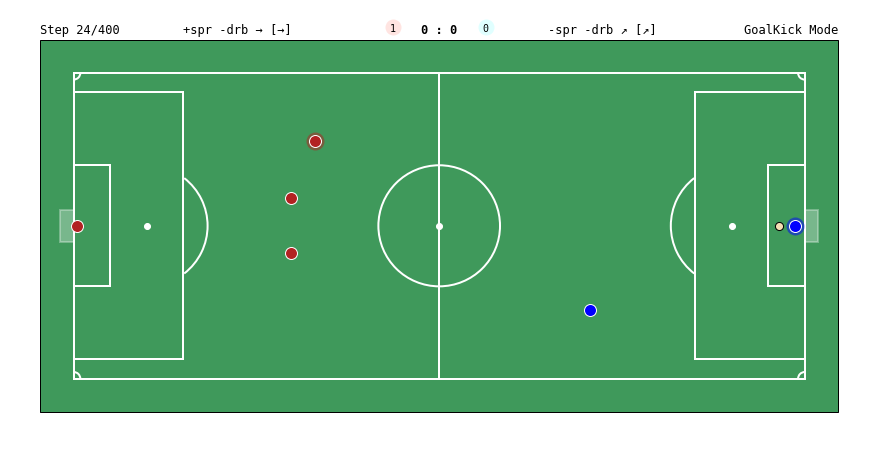

In [166]:
from IPython.display import HTML
from visualizer import visualize
#viz = visualize(output)
viz = visualize(output)
HTML(viz.to_html5_video())

In [ ]:
def get_basic_df2(output):
    steps = output
    steps_lists = []

    for step_num in range(len(steps)):
        #print(i)
        step = steps[step_num]
        # get left or right player based on if matches team we want
        obs_step = step[0]

        if step_num == 0:
            action = None
            action_str = None
        else:
            action = obs_step['action'][0]
            action_str = action_set_dic[action]


        status = obs_step['status']
        observation = obs_step['observation']
        players_raw = observation['players_raw'][0]

        active_player = players_raw['active']

        game_mode = players_raw['game_mode']
        game_mode_str = game_mode_dic[game_mode]

        # score
        left_score = players_raw['score'][0]
        right_score = players_raw['score'][1]

        # steps
        steps_left = players_raw['steps_left']

        # ball owned team  {-1, 0, 1}, -1 = ball not owned, 0 = left team, 1 = right team.
        ball_owned_team = players_raw['ball_owned_team']
        # we need to map ball owned based on if left or right agent
        if ball_owned_team == -1:
            off_def_flag = 'none'
        elif ball_owned_team == 0:
            off_def_flag = 'offense'
        elif ball_owned_team == 1:
            off_def_flag = 'defense'

        # now create dataframe
        step_list = [step_num, action, action_str, game_mode_str, active_player, off_def_flag, left_score, right_score]
        steps_lists.append(step_list)


    df_columns = ['step_num', 'action', 'action_str', 'game_mode_str', 'active_player', 'off_def_flag', 'left_score', 'right_score']
    basic_df = pd.DataFrame(steps_lists, columns = df_columns)
    return basic_df

In [168]:
 0.7386271953582764 + 0.0085914833471179

0.7472186787053943

In [171]:
-0.05020221322774887 + -0.004359409678727388

-0.05456162290647626

In [270]:
env = make("football", debug=True,
           configuration={"save_video": False, 
                          "scenario_name": 'academy_3_vs_1_with_keeper', 
                          "running_in_notebook": True,
                          #"numSteps": 500
                         })

agent1 = "../submit_agents/gfootball-with-memory-patterns/submission_v55.py"
agent2 = "../submit_agents/gfootball-with-memory-patterns/submission_v55.py"
output = env.run([agent1, agent2])

scores = output[-1][0]["observation"]["players_raw"][0]["score"]
print("Scores  {0} : {1}".format(*scores))
print("Rewards {0} : {1}".format(output[-1][0]["reward"], output[-1][1]["reward"]))
print('NUM STEPS: {0}'.format(len(output)))

Staring a new environment 94d7fc08-aa7e-4970-80aa-51f3afd2decf: with scenario: academy_3_vs_1_with_keeper
Resetting environment 94d7fc08-aa7e-4970-80aa-51f3afd2decf: with scenario: academy_3_vs_1_with_keeper
Scores  0 : 0
Rewards 0 : 0
NUM STEPS: 13


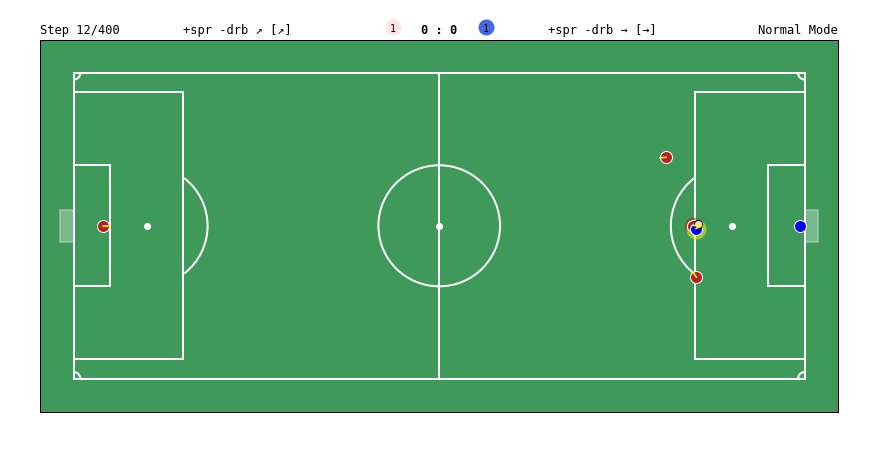

In [271]:
viz = visualize(output)
HTML(viz.to_html5_video())

In [274]:
%%time
env = make("football", debug=True,
           configuration={"save_video": False, 
                          "scenario_name": '11_vs_11_kaggle', 
                          "running_in_notebook": True,
                          "episodeSteps": 1500
                         })

agent1 = "../submit_agents/gfootball-with-memory-patterns/submission_v55.py"
agent2 = "../submit_agents/gfootball-with-memory-patterns/submission_v55.py"
#agent1 = "../submit_agents/tunable-baseline-bot/submission_v6.py"
#agent2 = "../submit_agents/tunable-baseline-bot/submission_v6.py"
../submit_agents/tunable-baseline-bot/submission_v6.py"
output = env.run([agent1, agent2])

scores = output[-1][0]["observation"]["players_raw"][0]["score"]
print("Scores  {0} : {1}".format(*scores))
print("Rewards {0} : {1}".format(output[-1][0]["reward"], output[-1][1]["reward"]))
print('NUM STEPS: {0}'.format(len(output)))

Staring a new environment f4c7ef1e-b5ed-434b-b780-242c370afa4a: with scenario: 11_vs_11_kaggle
Resetting environment f4c7ef1e-b5ed-434b-b780-242c370afa4a: with scenario: 11_vs_11_kaggle
Scores  1 : 0
Rewards 1 : -1
NUM STEPS: 1500
CPU times: user 23.6 s, sys: 431 ms, total: 24.1 s
Wall time: 23.7 s


In [ ]:
%%time
env = make("football", debug=True,
           configuration={"save_video": False, 
                          "scenario_name": '11_vs_11_kaggle', 
                          "running_in_notebook": True,
                          "numSteps": 500
                         })

agent1 = "../submit_agents/gfootball-with-memory-patterns/submission_v55.py"
agent2 = "../submit_agents/gfootball-with-memory-patterns/submission_v55.py"
output = env.run([agent1, agent2])

scores = output[-1][0]["observation"]["players_raw"][0]["score"]
print("Scores  {0} : {1}".format(*scores))
print("Rewards {0} : {1}".format(output[-1][0]["reward"], output[-1][1]["reward"]))
print('NUM STEPS: {0}'.format(len(output)))